<a href="https://colab.research.google.com/github/ajitkumarkp/ML/blob/master/Pytorch_Optimization_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font style="color:blue">Optimization Algorithms</font>

This notebook covers the Pytorch implementation of common optimizers (Gradient Descent, Gradient Descent with Momentum, RMSprop, and  Adam). 

`torch.optim` is a PyTorch package where various optimization algorithms are implemented, for all the optimizers and their parameters ref- [here](https://pytorch.org/docs/stable/optim.html).

LeNet Network with the Fashion MNIST dataset  is used here to illustrate the convergence of different optimization algorithms.

Specifically, `Steps 10 to 13`, covers how the different optimizers are initialized and used to train the network. The same learning rate is set for all optimizers.

In [ ]:
%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt  # one of the best graphics library for python
plt.style.use('ggplot')

In [ ]:
import os
import time

from typing import Iterable
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms

# <font style="color:blue">1. LeNet Architecture</font>


In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()

        # convolution layers
        self._body = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        
        # Fully connected layers
        self._head = nn.Sequential(
            
            nn.Linear(in_features=16 * 5 * 5, out_features=120), 
            nn.ReLU(inplace=True),
            
            nn.Linear(in_features=120, out_features=84), 
            nn.ReLU(inplace=True),
            
            nn.Linear(in_features=84, out_features=10)
        )

    def forward(self, x):
        # apply feature extractor
        x = self._body(x)
        # flatten the output of conv layers
        # dimension should be batch_size * number_of weight_in_last conv_layer
        x = x.view(x.size()[0], -1)
        # apply classification head
        x = self._head(x)
        return x

# <font style="color:blue">2. Display the Network</font>

In [ ]:
lenet_model = LeNet()
print(lenet_model)

LeNet(
  (_body): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (_head): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


# <font style="color:blue">3. Get Fashion MNIST Data</font>

In [ ]:
def get_data(batch_size, data_root='data', num_workers=1):
    
    train_test_transforms = transforms.Compose([
        # Resize to 32X32
        transforms.Resize((32, 32)),
        # this re-scale image tensor values between 0-1. image_tensor /= 255
        transforms.ToTensor(),
        # subtract mean (0.2860) and divide by variance (0.3530).
        # This mean and variance is calculated on training data (verify yourself)
        transforms.Normalize((0.2860, ), (0.3530, ))
    ])
    
    # train dataloader
    train_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST(root=data_root, train=True, download=True, transform=train_test_transforms),
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )
    
    # test dataloader
    test_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST(root=data_root, train=False, download=True, transform=train_test_transforms),
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )
    return train_loader, test_loader

# <font style="color:blue">4. System Configuration</font>

In [ ]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 21  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

# <font style="color:blue">5. Training Configuration</font>
Setting a learning rate of 0.001 

In [ ]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 64  # amount of data to pass through the network at each forward-backward iteration
    epochs_count: int = 30  # number of times the whole dataset will be passed through the network
    learning_rate: float = 0.001  # determines the speed of network's weights update
    log_interval: int = 500  # how many batches to wait between logging training status
    test_interval: int = 1  # how many epochs to wait before another test. Set to 1 to get val loss at each epoch
    data_root: str = "./data"  # folder to save Fashion MNIST data (default: data)
    num_workers: int = 10  # number of concurrent processes using to prepare data
    device: str = 'cuda'  # device to use for training.
    


# <font style="color:blue">6. System Setup</font>

In [ ]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

# <font style="color:blue">7. Training</font>
Typical training pipeline used in PyTorch.

In [ ]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int
) -> None:
    
    # change model in training mood
    model.train()
    
    # to get batch loss
    batch_loss = np.array([])
    
    # to get batch accuracy
    batch_acc = np.array([])
        
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # clone target
        indx_target = target.clone()
        # send data to device (its is medatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad()
        
        # forward pass to the model
        output = model(data)
        
        # cross entropy loss
        loss = F.cross_entropy(output, target)
        
        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gardients
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
            
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]  
                        
        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()
            
        # accuracy
        acc = float(correct) / float(len(data))
        
        batch_acc = np.append(batch_acc, [acc])

#         if batch_idx % train_config.log_interval == 0 and batch_idx > 0:              
#             print(
#                 'Train Epoch: {} [{}/{}] Loss: {:.6f} Acc: {:.4f}'.format(
#                     epoch_idx, batch_idx * len(data), len(train_loader.dataset), loss.item(), acc
#                 )
#             )
            
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    
    print('\nEpoch: {} Loss: {:.6f} Acc: {:.4f}'.format(epoch_idx, epoch_loss, epoch_acc))

    return epoch_loss, epoch_acc

# <font style="color:blue">8. Validation</font>

In [ ]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> float:
    # 
    model.eval()
    test_loss = 0
    count_corect_predictions = 0
    for data, target in test_loader:
        indx_target = target.clone()
        data = data.to(train_config.device)
        
        target = target.to(train_config.device)
        
        output = model(data)
        # add loss for each mini batch
        test_loss += F.cross_entropy(output, target).item()
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
        
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1] 
        
        # add correct prediction count
        count_corect_predictions += pred.cpu().eq(indx_target).sum()

    # average over number of mini-batches
    test_loss = test_loss / len(test_loader)  
    
    # average over number of dataset
    accuracy = 100. * count_corect_predictions / len(test_loader.dataset)
    
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
        )
    )
    return test_loss, accuracy/100.0

# <font style="color:blue">9. Main</font>

The configuration parameters defined above are used to start training. Following are the steps:

1. Set up system parameters like CPU/GPU, number of threads etc
1. Load the data using dataloaders
1. For each epoch, call train function. 
1. Set up variables to track loss and accuracy and start training.



In [ ]:
def main(model, optimizer, system_configuration=SystemConfiguration(), 
         training_configuration=TrainingConfiguration()):
    
    # system configuration
    setup_system(system_configuration)

    # batch size
    batch_size_to_set = training_configuration.batch_size
    # num_workers
    num_workers_to_set = training_configuration.num_workers
    # epochs
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config, 
    # else lowers batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 2

    # data loader
    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set
    )
    
    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )
        
    # send model to device (GPU/CPU)
    model.to(training_configuration.device)

    best_loss = torch.tensor(np.inf)
    
    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    
    # epch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])
    
    # trainig time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):
        
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch)
        
        epoch_train_loss = np.append(epoch_train_loss, [train_loss])
        
        epoch_train_acc = np.append(epoch_train_acc, [train_acc])

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        
        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )
    
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

# <font style="color:blue">10. Training using SGD (Gradient Descent)</font>

**Gradient descent update rule:**

$$
W_t = W_{t-1} -\alpha g_{t-1}
$$

where,

$$
W = \begin{bmatrix}
           w_{1} \\
           w_{2} \\
           \vdots \\
           w_{n}
         \end{bmatrix}
$$

and,


$$
g = \begin{bmatrix}
           \frac{\partial L}{\partial w_1} \\
           \frac{\partial L}{\partial w_2}  \\
           \vdots \\
           \frac{\partial L}{\partial w_n} 
         \end{bmatrix}
$$

**For stochastic gradient descent update, we use the following method in PyTorch:** 


```
torch.optim.SGD(params, lr=<required parameter>, momentum=0, dampening=0, weight_decay=0, nesterov=False)
```
- **`params`** (iterable) – iterable of parameters to optimize or dicts defining parameter groups. `model.parameters()` gives iterable model parameters. [Required]

- **`lr`** (python:float) – learning rate [Required]

- `momentum` (python:float, optional) – momentum factor (default: 0)

- `weight_decay` (python:float, optional) – weight decay (L2 penalty) (default: 0)

- `dampening` (python:float, optional) – dampening for momentum (default: 0)

- `nesterov` (bool, optional) – enables Nesterov momentum (default: False)

Find details [here](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD).

In [ ]:
model = LeNet()

train_config = TrainingConfiguration()

# optimizer
optimizer = optim.SGD(
    model.parameters(),
    lr=train_config.learning_rate
)


model, train_loss_sgd, train_acc_sgd, test_loss_sgd, test_acc_sgd = main(model, optimizer)



Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.



Epoch: 0 Loss: 2.297148 Acc: 0.1625
Elapsed 16.39s, 16.39 s/epoch, 0.02 s/batch, ets 475.20s

Epoch: 1 Loss: 2.272109 Acc: 0.2075
Elapsed 32.93s, 16.46 s/epoch, 0.02 s/batch, ets 460.97s

Epoch: 2 Loss: 2.174577 Acc: 0.2755
Elapsed 49.35s, 16.45 s/epoch, 0.02 s/batch, ets 444.17s

Epoch: 3 Loss: 1.604789 Acc: 0.4651
Elapsed 65.93s, 16.48 s/epoch, 0.02 s/batch, ets 428.57s

Epoch: 4 Loss: 1.071613 Acc: 0.6244
Elapsed 82.55s, 16.51 s/epoch, 0.02 s/batch, ets 412.77s

Epoch: 5 Loss: 0.949913 Acc: 0.6654
Elapsed 99.14s, 16.52 s/epoch, 0.02 s/batch, ets 396.56s

Epoch: 6 Loss: 0.878363 Acc: 0.6894
Elapsed 116.21s, 16.60 s/epoch, 0.02 s/batch, ets 381.83s

Epoch: 7 Loss: 0.822150 Acc: 0.7077
Elapsed 132.88s, 16.61 s/epoch, 0.02 s/batch, ets 365.41s

Epoch: 8 Loss: 0.779307 Acc: 0.7184
Elapsed 149.47s, 16.61 s/epoch, 0.02 s/batch, ets 348.76s

Epoch: 9 Loss: 0.745793 Acc: 0.7285
Elapsed 166.00s, 16.60 s/epoch, 0.02 s/batch, ets 332.01s

Epoch: 10 Loss: 0.719496 Acc: 0.7367
Elapsed 182.80s, 1

# <font style="color:blue">11. Training using SGD with Momentum</font>

**Gradient descent with momentun update rule:**

$$
\begin{align}
v_t &= \beta v_{t-1} + (1 - \beta) g_{t-1} \\
\\
W_t &= W_{t-1} - \alpha v_t \\
\end{align}
$$


**In PyTorch, we use `torch.optim.SGD` with non-zero momentum value.**

In the following training, we will use $\beta = 0.9$. Here $\beta$ is momentum.


In [ ]:
model = LeNet()

train_config = TrainingConfiguration()

# optimizer
optimizer = optim.SGD(
    model.parameters(),
    lr=train_config.learning_rate,
    # to use momentum, changed default value 0 to 0.9
    momentum = 0.9
)


model, train_loss_sgd_momentum, train_acc_sgd_momentum, test_loss_sgd_momentum, test_acc_sgd_momentum = main(
    model, 
    optimizer)




Epoch: 0 Loss: 1.230978 Acc: 0.5730
Elapsed 16.71s, 16.71 s/epoch, 0.02 s/batch, ets 484.64s

Epoch: 1 Loss: 0.575522 Acc: 0.7810
Elapsed 33.61s, 16.81 s/epoch, 0.02 s/batch, ets 470.61s

Epoch: 2 Loss: 0.507567 Acc: 0.8088
Elapsed 50.63s, 16.88 s/epoch, 0.02 s/batch, ets 455.70s

Epoch: 3 Loss: 0.464286 Acc: 0.8282
Elapsed 67.45s, 16.86 s/epoch, 0.02 s/batch, ets 438.45s

Epoch: 4 Loss: 0.432519 Acc: 0.8408
Elapsed 84.31s, 16.86 s/epoch, 0.02 s/batch, ets 421.55s

Epoch: 5 Loss: 0.408148 Acc: 0.8498
Elapsed 101.17s, 16.86 s/epoch, 0.02 s/batch, ets 404.66s

Epoch: 6 Loss: 0.390901 Acc: 0.8560
Elapsed 117.88s, 16.84 s/epoch, 0.02 s/batch, ets 387.31s

Epoch: 7 Loss: 0.376440 Acc: 0.8626
Elapsed 134.87s, 16.86 s/epoch, 0.02 s/batch, ets 370.90s

Epoch: 8 Loss: 0.364184 Acc: 0.8668
Elapsed 151.83s, 16.87 s/epoch, 0.02 s/batch, ets 354.26s

Epoch: 9 Loss: 0.351480 Acc: 0.8715
Elapsed 168.79s, 16.88 s/epoch, 0.02 s/batch, ets 337.59s

Epoch: 10 Loss: 0.342389 Acc: 0.8732
Elapsed 185.66s, 

# <font style="color:blue">12. Training using RMSProp</font>

**RMSProp update rule:**

$$
\begin{align}
s_t &= \beta s_{t-1} + (1 - \beta) g_{t-1}^2 \\
\\
W_t &= W_{t-1} - \alpha \frac {g_{t-1}}{\sqrt s_t + \epsilon} \\
\end{align}
$$

**For RMSProp weight update, we use the following method in PyTorch:** 

```
torch.optim.RMSprop(params, lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
```
- **`params`** (iterable) – iterable of parameters to optimize or dicts defining parameter groups

- `lr` (python:float, optional) – learning rate (default: 1e-2). $\alpha$ is learning rate in the `RMSProp` update rule.

- `momentum` (python:float, optional) – momentum factor (default: 0)

- `alpha` (python:float, optional) – smoothing constant (default: 0.99). $\beta$ is smothing constant in the `RMSProp` update rule.

- `eps` (python:float, optional) – term added to the denominator to improve numerical stability (default: 1e-8). This $\epsilon$ is the `RMSProp` update rule.

- `centered` (bool, optional) – if True, compute the centered RMSProp, the gradient is normalized by an estimation of its variance

- `weight_decay` (python:float, optional) – weight decay (L2 penalty) (default: 0)



Find details [here](https://pytorch.org/docs/stable/optim.html#torch.optim.RMSprop).

In [ ]:
model = LeNet()

train_config = TrainingConfiguration()

# optimizer
optimizer = optim.RMSprop(
    model.parameters(),
    lr=train_config.learning_rate
)


model, train_loss_rms_prop, train_acc_rms_prop, test_loss_rms_prop, test_acc_rms_prop = main(model, optimizer)




Epoch: 0 Loss: 0.521146 Acc: 0.8040
Elapsed 17.17s, 17.17 s/epoch, 0.02 s/batch, ets 497.98s

Epoch: 1 Loss: 0.355065 Acc: 0.8690
Elapsed 34.50s, 17.25 s/epoch, 0.02 s/batch, ets 483.00s

Epoch: 2 Loss: 0.309326 Acc: 0.8855
Elapsed 51.69s, 17.23 s/epoch, 0.02 s/batch, ets 465.25s

Epoch: 3 Loss: 0.280314 Acc: 0.8960
Elapsed 68.61s, 17.15 s/epoch, 0.02 s/batch, ets 445.98s

Epoch: 4 Loss: 0.258923 Acc: 0.9032
Elapsed 85.68s, 17.14 s/epoch, 0.02 s/batch, ets 428.40s

Epoch: 5 Loss: 0.242164 Acc: 0.9098
Elapsed 102.67s, 17.11 s/epoch, 0.02 s/batch, ets 410.70s

Epoch: 6 Loss: 0.226890 Acc: 0.9154
Elapsed 119.78s, 17.11 s/epoch, 0.02 s/batch, ets 393.56s

Epoch: 7 Loss: 0.214073 Acc: 0.9198
Elapsed 136.54s, 17.07 s/epoch, 0.02 s/batch, ets 375.48s

Epoch: 8 Loss: 0.202583 Acc: 0.9233
Elapsed 153.47s, 17.05 s/epoch, 0.02 s/batch, ets 358.10s

Epoch: 9 Loss: 0.193581 Acc: 0.9267
Elapsed 170.47s, 17.05 s/epoch, 0.02 s/batch, ets 340.93s

Epoch: 10 Loss: 0.182661 Acc: 0.9318
Elapsed 187.40s, 

# <font style="color:blue">13. Training using Adam (Momentum + RMSProp)</font>

**Adam update rule:**
$$
\begin{align}
v_t &= \beta_1 v_{t-1} + (1 - \beta_1) g_{t-1} \\
\\
s_t &= \beta_2 s_{t-1} + (1 - \beta_2) g_{t-1}^2 \\
\\
W_t &= W_{t-1} - \alpha \frac {v_{t}}{\sqrt s_t + \epsilon} \\
\end{align}
$$

**For Adam weight update, we use the following method in PyTorch:**

```
torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
```
- **`params`** (iterable) – iterable of parameters to optimize or dicts defining parameter groups

- `lr` (python:float, optional) – learning rate (default: `1e-3`). $\alpha$ is learning rate in Adam update rule.

- `betas` (Tuple[python:float, python:float], optional) – coefficients used for computing running averages of gradient and its square (default: `(0.9, 0.999)`). In Adam update rule, first value of tuple is $\beta_1$ and second value is $\beta_2$

- `weight_decay` (python:float, optional) – weight decay (L2 penalty) (default: `0`)

- `amsgrad` (boolean, optional) – whether to use the AMSGrad variant of this algorithm from the paper On the [Convergence of Adam and Beyond](https://openreview.net/forum?id=ryQu7f-RZ) (default: False)




Find details [here](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam).

In [ ]:
model = LeNet()

train_config = TrainingConfiguration()

# optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr=train_config.learning_rate
)


model, train_loss_adam, train_acc_adam, test_loss_adam, test_acc_adam = main(model, optimizer)




Epoch: 0 Loss: 0.557727 Acc: 0.7929
Elapsed 17.94s, 17.94 s/epoch, 0.02 s/batch, ets 520.29s

Epoch: 1 Loss: 0.368295 Acc: 0.8647
Elapsed 35.92s, 17.96 s/epoch, 0.02 s/batch, ets 502.93s

Epoch: 2 Loss: 0.319453 Acc: 0.8831
Elapsed 53.62s, 17.87 s/epoch, 0.02 s/batch, ets 482.62s

Epoch: 3 Loss: 0.291018 Acc: 0.8928
Elapsed 71.09s, 17.77 s/epoch, 0.02 s/batch, ets 462.11s

Epoch: 4 Loss: 0.269919 Acc: 0.9006
Elapsed 88.47s, 17.69 s/epoch, 0.02 s/batch, ets 442.35s

Epoch: 5 Loss: 0.249957 Acc: 0.9065
Elapsed 105.88s, 17.65 s/epoch, 0.02 s/batch, ets 423.52s

Epoch: 6 Loss: 0.235996 Acc: 0.9123
Elapsed 123.19s, 17.60 s/epoch, 0.02 s/batch, ets 404.75s

Epoch: 7 Loss: 0.223320 Acc: 0.9159
Elapsed 140.51s, 17.56 s/epoch, 0.02 s/batch, ets 386.40s

Epoch: 8 Loss: 0.209684 Acc: 0.9211
Elapsed 157.79s, 17.53 s/epoch, 0.02 s/batch, ets 368.17s

Epoch: 9 Loss: 0.198275 Acc: 0.9254
Elapsed 174.88s, 17.49 s/epoch, 0.02 s/batch, ets 349.77s

Epoch: 10 Loss: 0.189109 Acc: 0.9290
Elapsed 192.03s, 

# <font style="color:blue">14. Plot Loss Curves</font>

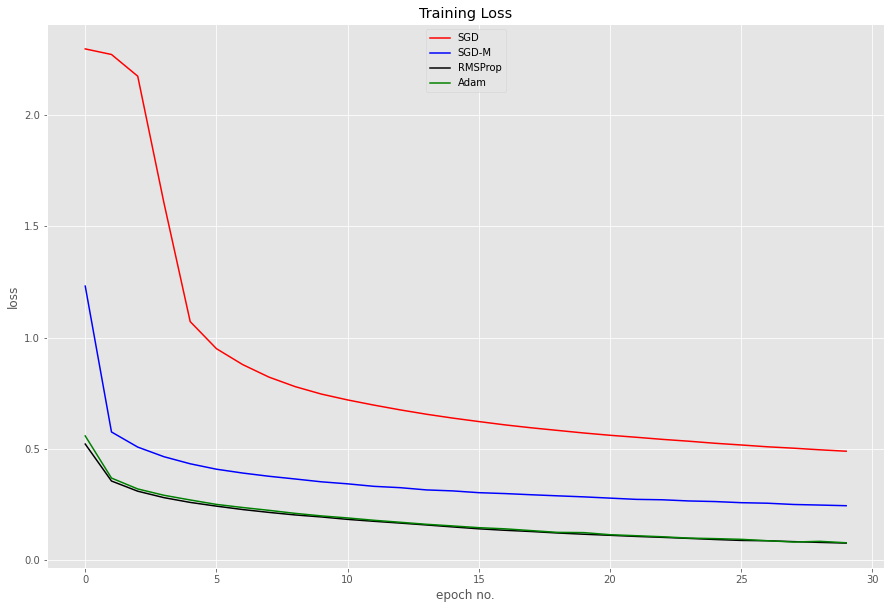

In [ ]:
# Plot loss
plt.rcParams["figure.figsize"] = (15, 10)
x = range(len(train_loss_sgd))

plt.figure
plt.plot(x, train_loss_sgd, 'r', label="SGD")

plt.plot(x, train_loss_sgd_momentum, 'b', label="SGD-M")

plt.plot(x, train_loss_rms_prop, 'k', label="RMSProp")

plt.plot(x, train_loss_adam, 'g', label="Adam")

plt.xlabel('epoch no.')
plt.ylabel('loss')
plt.legend(loc='upper center')
plt.title('Training Loss')
plt.show()

# <font style="color:blue">Conclusion</font>
The loss decreases in the following order: Adam = RMSProp > SGD-Momentum > SGD 